In [7]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import seaborn as sns

In [8]:
df = pd.read_csv('compas-scores-two-years.csv')
df = df[df.race.isin(['Caucasian', 'African-American'])]

In [9]:
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
6,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,...,2,Low,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1
8,10,elizabeth thieme,elizabeth,thieme,2014-03-16,Female,1976-06-03,39,25 - 45,Caucasian,...,1,Low,2014-03-16,2014-03-15,2014-03-18,0,2,747,0,0


### Tratando os dados

Assim como a análise da ProPublica 

In [10]:
column_names = ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count',
                'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid',
                'c_jail_in', 'c_jail_out']

In [11]:
df = df[df['days_b_screening_arrest'] <= 30]
df = df[df['days_b_screening_arrest'] >= -30]
df = df[df['is_recid'] != -1]
df = df[df['c_charge_degree'] != 'O']
df = df[df['score_text'] != 'N/A']
df[column_names].head()

,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out
1,34,F,African-American,25 - 45,Low,Male,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53
2,24,F,African-American,Less than 25,Low,Male,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04
6,41,F,Caucasian,25 - 45,Medium,Male,14,-1.0,6,1,1,2014-02-18 05:08:24,2014-02-24 12:18:30
8,39,M,Caucasian,25 - 45,Low,Female,0,-1.0,1,0,0,2014-03-15 05:35:34,2014-03-18 04:28:46
10,27,F,Caucasian,25 - 45,Low,Male,0,-1.0,4,0,0,2013-11-25 06:31:06,2013-11-26 08:26:57


In [12]:
sex_dict = dict(enumerate(df['sex'].astype('category').cat.categories))
print(sex_dict)
df['c_sex'] = df['sex'].astype('category').cat.codes

{0: 'Female', 1: 'Male'}


In [13]:
age_dict = dict(enumerate(df['age_cat'].astype('category').cat.categories))
print(age_dict)
df['c_age_cat'] = df['age_cat'].astype('category').cat.codes

{0: '25 - 45', 1: 'Greater than 45', 2: 'Less than 25'}


In [14]:
charge_dict = dict(enumerate(df['c_charge_degree'].astype('category').cat.categories))
print(charge_dict)
df['c_c_charge_degree'] = df['c_charge_degree'].astype('category').cat.codes

{0: 'F', 1: 'M'}


In [15]:
race_dict = dict(enumerate(df['race'].astype('category').cat.categories))
print(race_dict)
df['c_race'] = df['race'].astype('category').cat.codes

{0: 'African-American', 1: 'Caucasian'}


In [16]:
score_dict = dict(enumerate(df['score_text'].astype('category').cat.categories))
print(score_dict)
df['c_score_text'] = df['score_text'].astype('category').cat.codes

{0: 'High', 1: 'Low', 2: 'Medium'}


In [17]:
# df['c_jail_in'].astype('datetime64').astype('int64')
df['length_of_stay'] =  df['c_jail_out'].astype('datetime64').astype('int64') - df['c_jail_in'].astype('datetime64').astype('int64')

In [18]:
c_column_names = ['age', 'c_c_charge_degree', 'c_race', 'c_age_cat', 'c_score_text', 'c_sex', 'priors_count',
                'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid']
# c_column_names = ['age', 'c_c_charge_degree', 'c_race', 'c_age_cat', 'c_score_text', 'c_sex', 'priors_count',
#                 'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid', 'length_of_stay']
df[c_column_names].head()

,age,c_c_charge_degree,c_race,c_age_cat,c_score_text,c_sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid
1,34,0,0,0,1,1,0,-1.0,3,1,1
2,24,0,0,2,1,1,4,-1.0,4,1,1
6,41,0,1,0,2,1,14,-1.0,6,1,1
8,39,1,1,0,1,0,0,-1.0,1,0,0
10,27,0,1,0,1,1,0,-1.0,4,0,0


In [19]:
df2 = df[c_column_names]
X = df2.loc[:, df2.columns != 'two_year_recid']
X = X.loc[:, X.columns != 'decile_score']
X.head()

,age,c_c_charge_degree,c_race,c_age_cat,c_score_text,c_sex,priors_count,days_b_screening_arrest,is_recid
1,34,0,0,0,1,1,0,-1.0,1
2,24,0,0,2,1,1,4,-1.0,1
6,41,0,1,0,2,1,14,-1.0,1
8,39,1,1,0,1,0,0,-1.0,0
10,27,0,1,0,1,1,0,-1.0,0


In [20]:
# y = df2['two_year_recid']
y = df2['decile_score']
y.head()

1     3
2     4
6     6
8     1
10    4
Name: decile_score, dtype: int64

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
logistic_regression_cv = LogisticRegressionCV(
    cv=5, max_iter=10000, n_jobs=2, verbose=1, multi_class="auto").fit(
    X_train, y_train)


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   39.6s finished


In [23]:
y_pred = logistic_regression_cv.predict(X_test)

In [34]:
prfs = precision_recall_fscore_support(y_test, y_pred)
prfs[:-1]
# result = pd.DataFrame(prfs[:-1],columns=["Precisão", "Revocação", "F1"])

(array([0.62907268, 0.42105263, 0.44      , 0.41791045, 0.45081967,
        0.40625   , 0.37795276, 0.38461538, 0.34677419, 0.48275862]),
 array([0.87456446, 0.45070423, 0.06145251, 0.48554913, 0.71895425,
        0.17808219, 0.35294118, 0.50458716, 0.40186916, 0.17283951]),
 array([0.73177843, 0.43537415, 0.10784314, 0.44919786, 0.55415617,
        0.24761905, 0.36501901, 0.43650794, 0.37229437, 0.25454545]))

### Cálculo das métricas

In [35]:
df_temp = X_test
df_temp['pred_decile_score'] = y_pred
df_temp['pred_decile_score'][89]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


7

In [36]:
df_metrics = X_test.copy()
df_metrics['pred_decile_score'] = y_pred
df_metrics['two_year_recid'] = df2['two_year_recid']

## Calibration assessment

In [37]:
df_calibration= pd.DataFrame(columns=['Score','Probability', 'Race'])

In [38]:
# matrix = threshold x race_code

for score in range(1, 11):
    for race_code in range(0, 2):
        result_df = df_metrics[df_metrics["pred_decile_score"] == score]
        result_df = result_df[result_df["c_race"] == race_code]
        result_df = result_df[result_df["two_year_recid"] == 1]
        num = result_df.size

        result_df = df_metrics[df_metrics["pred_decile_score"] == score]
        result_df = result_df[result_df["c_race"] == race_code]
        dem = result_df.size
        df_calibration = df_calibration.append({'Score': score, 'Probability':num/dem , 'Race' : race_code} , ignore_index=True)
        print("Score: ", score, "race_code: ", race_code,  "num: ",  num,  "dem: ",  dem, " num/dem: ", num/dem)

Score:  1 race_code:  0 num:  352 dem:  1551  num/dem:  0.22695035460992907
Score:  1 race_code:  1 num:  671 dem:  2838  num/dem:  0.2364341085271318
Score:  2 race_code:  0 num:  440 dem:  1551  num/dem:  0.28368794326241137
Score:  2 race_code:  1 num:  330 dem:  957  num/dem:  0.3448275862068966
Score:  3 race_code:  0 num:  11 dem:  187  num/dem:  0.058823529411764705
Score:  3 race_code:  1 num:  22 dem:  88  num/dem:  0.25
Score:  4 race_code:  0 num:  957 dem:  1518  num/dem:  0.6304347826086957
Score:  4 race_code:  1 num:  363 dem:  693  num/dem:  0.5238095238095238
Score:  5 race_code:  0 num:  286 dem:  1408  num/dem:  0.203125
Score:  5 race_code:  1 num:  517 dem:  1276  num/dem:  0.4051724137931034
Score:  6 race_code:  0 num:  319 dem:  407  num/dem:  0.7837837837837838
Score:  6 race_code:  1 num:  275 dem:  297  num/dem:  0.9259259259259259
Score:  7 race_code:  0 num:  1067 dem:  1342  num/dem:  0.7950819672131147
Score:  7 race_code:  1 num:  55 dem:  55  num/dem:  

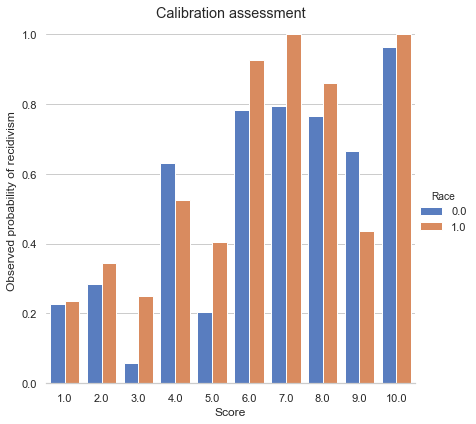

In [44]:
sns.set(style="whitegrid")

# Draw a nested barplot to show survival for class and sex
g = sns.catplot(x="Score", y="Probability", hue="Race", data=df_calibration,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.fig.suptitle('Calibration assessment')
g.set_ylabels("Observed probability of recidivism")
g.savefig("calibration.png")

## Predictive Parity assessment

In [45]:
df_errorRate= pd.DataFrame(columns=['Threshold','Probability', 'Race'])

In [46]:
# matrix = threshold x race_code

for threshold in range(0, 10):
    for race_code in range(0, 2):
        result_df = df_metrics[df_metrics["pred_decile_score"] > threshold]
        result_df = result_df[result_df["c_race"] == race_code]
        result_df = result_df[result_df["two_year_recid"] == 1]
        num = result_df.size

        result_df = df_metrics[df_metrics["c_race"] == race_code]
        result_df = result_df[result_df["pred_decile_score"] > threshold]
        dem = result_df.size
        df_errorRate = df_errorRate.append({'Threshold': threshold, 'Probability':num/dem , 'Race' : race_code} , ignore_index=True)
        print("Threshold: ", threshold, "race_code: ", race_code,  "num: ",  num,  "dem: ",  dem, " num/dem: ", num/dem)

Threshold:  0 race_code:  0 num:  5412 dem:  10626  num/dem:  0.5093167701863354
Threshold:  0 race_code:  1 num:  2673 dem:  6798  num/dem:  0.3932038834951456
Threshold:  1 race_code:  0 num:  5060 dem:  9075  num/dem:  0.5575757575757576
Threshold:  1 race_code:  1 num:  2002 dem:  3960  num/dem:  0.5055555555555555
Threshold:  2 race_code:  0 num:  4620 dem:  7524  num/dem:  0.6140350877192983
Threshold:  2 race_code:  1 num:  1672 dem:  3003  num/dem:  0.5567765567765568
Threshold:  3 race_code:  0 num:  4609 dem:  7337  num/dem:  0.6281859070464768
Threshold:  3 race_code:  1 num:  1650 dem:  2915  num/dem:  0.5660377358490566
Threshold:  4 race_code:  0 num:  3652 dem:  5819  num/dem:  0.6275992438563327
Threshold:  4 race_code:  1 num:  1287 dem:  2222  num/dem:  0.5792079207920792
Threshold:  5 race_code:  0 num:  3366 dem:  4411  num/dem:  0.7630922693266833
Threshold:  5 race_code:  1 num:  770 dem:  946  num/dem:  0.813953488372093
Threshold:  6 race_code:  0 num:  3047 dem

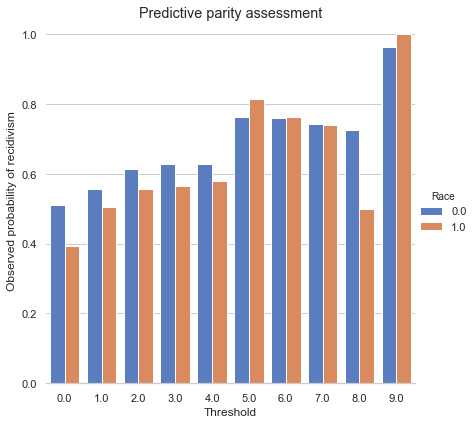

In [48]:
sns.set(style="whitegrid")

# Draw a nested barplot to show survival for class and sex
g = sns.catplot(x="Threshold", y="Probability", hue="Race", data=df_errorRate,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Observed probability of recidivism")
g.fig.suptitle('Predictive parity assessment')
g.savefig("predictiveparity.png")

## Rerror balance assessment: FPR

In [49]:
df_errorRate= pd.DataFrame(columns=['Threshold','Probability', 'Race'])

In [50]:
# matrix = threshold x race_code

for threshold in range(0, 10):
    for race_code in range(0, 2):
        result_df = df_metrics[df_metrics["pred_decile_score"] > threshold]
        result_df = result_df[result_df["c_race"] == race_code]
        result_df = result_df[result_df["two_year_recid"] == 0]
        num = result_df.size

        result_df = df_metrics[df_metrics["c_race"] == race_code]
        result_df = result_df[result_df["two_year_recid"] == 0]
        dem = result_df.size
        df_errorRate = df_errorRate.append({'Threshold': threshold, 'Probability':num/dem , 'Race' : race_code} , ignore_index=True)
        print("Threshold: ", threshold, "race_code: ", race_code,  "num: ",  num,  "dem: ",  dem, " num/dem: ", num/dem)

Threshold:  0 race_code:  0 num:  5214 dem:  5214  num/dem:  1.0
Threshold:  0 race_code:  1 num:  4125 dem:  4125  num/dem:  1.0
Threshold:  1 race_code:  0 num:  4015 dem:  5214  num/dem:  0.770042194092827
Threshold:  1 race_code:  1 num:  1958 dem:  4125  num/dem:  0.4746666666666667
Threshold:  2 race_code:  0 num:  2904 dem:  5214  num/dem:  0.5569620253164557
Threshold:  2 race_code:  1 num:  1331 dem:  4125  num/dem:  0.32266666666666666
Threshold:  3 race_code:  0 num:  2728 dem:  5214  num/dem:  0.5232067510548524
Threshold:  3 race_code:  1 num:  1265 dem:  4125  num/dem:  0.30666666666666664
Threshold:  4 race_code:  0 num:  2167 dem:  5214  num/dem:  0.41561181434599154
Threshold:  4 race_code:  1 num:  935 dem:  4125  num/dem:  0.22666666666666666
Threshold:  5 race_code:  0 num:  1045 dem:  5214  num/dem:  0.20042194092827004
Threshold:  5 race_code:  1 num:  176 dem:  4125  num/dem:  0.042666666666666665
Threshold:  6 race_code:  0 num:  957 dem:  5214  num/dem:  0.1835

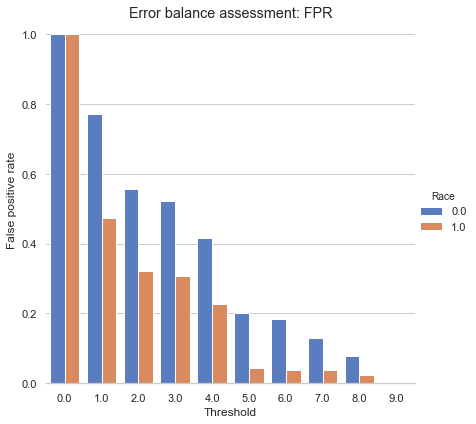

In [52]:
sns.set(style="whitegrid")

# Draw a nested barplot to show survival for class and sex
g = sns.catplot(x="Threshold", y="Probability", hue="Race", data=df_errorRate,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("False positive rate")
g.fig.suptitle('Error balance assessment: FPR')
g.savefig("errorFPR.png")

## Rerror balance assessment: FNR

In [53]:
df_errorNegative= pd.DataFrame(columns=['Threshold','Probability', 'Race'])

In [54]:
# matrix = threshold x race_code

for threshold in range(0, 10):
    for race_code in range(0, 2):
        result_df = df_metrics[df_metrics["pred_decile_score"] <= threshold]
        result_df = result_df[result_df["c_race"] == race_code]
        result_df = result_df[result_df["two_year_recid"] == 1]
        num = result_df.size

        result_df = df_metrics[df_metrics["c_race"] == race_code]
        result_df = result_df[result_df["two_year_recid"] == 1]
        dem = result_df.size
        df_errorNegative = df_errorNegative.append({'Threshold': threshold, 'Probability':num/dem , 'Race' : race_code} , ignore_index=True)
        print("Threshold: ", threshold, "race_code: ", race_code,  "num: ",  num,  "dem: ",  dem, " num/dem: ", num/dem)

Threshold:  0 race_code:  0 num:  0 dem:  5412  num/dem:  0.0
Threshold:  0 race_code:  1 num:  0 dem:  2673  num/dem:  0.0
Threshold:  1 race_code:  0 num:  352 dem:  5412  num/dem:  0.06504065040650407
Threshold:  1 race_code:  1 num:  671 dem:  2673  num/dem:  0.25102880658436216
Threshold:  2 race_code:  0 num:  792 dem:  5412  num/dem:  0.14634146341463414
Threshold:  2 race_code:  1 num:  1001 dem:  2673  num/dem:  0.37448559670781895
Threshold:  3 race_code:  0 num:  803 dem:  5412  num/dem:  0.1483739837398374
Threshold:  3 race_code:  1 num:  1023 dem:  2673  num/dem:  0.38271604938271603
Threshold:  4 race_code:  0 num:  1760 dem:  5412  num/dem:  0.3252032520325203
Threshold:  4 race_code:  1 num:  1386 dem:  2673  num/dem:  0.5185185185185185
Threshold:  5 race_code:  0 num:  2046 dem:  5412  num/dem:  0.3780487804878049
Threshold:  5 race_code:  1 num:  1903 dem:  2673  num/dem:  0.7119341563786008
Threshold:  6 race_code:  0 num:  2365 dem:  5412  num/dem:  0.436991869918

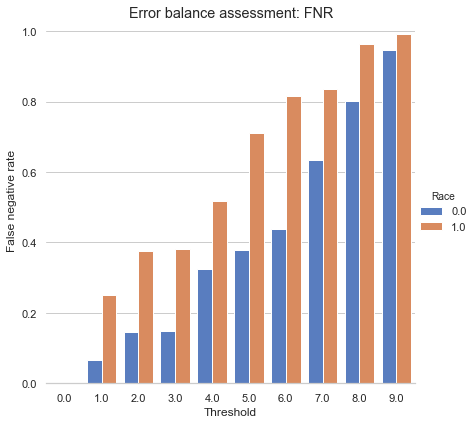

In [55]:
sns.set(style="whitegrid")

# Draw a nested barplot to show survival for class and sex
g = sns.catplot(x="Threshold", y="Probability", hue="Race", data=df_errorNegative,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("False negative rate")
g.fig.suptitle('Error balance assessment: FNR')
g.savefig("errorFNR.png")